In [ ]:
# !pip install tensorflow_data_validation
# !pip install seaborn


In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import tensorflow_data_validation as tfdv

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

%matplotlib inline

In [3]:
MAIN_DIR = "/content/drive/MyDrive/Kaggle/FSU23-Kaggle/" # change to your dir

In [4]:
train = pd.read_csv(MAIN_DIR+"training_data.csv")
train.head(3)

<ipython-input-4-e21efc5a6677>:1: DtypeWarning: Columns (15,19,23,24,102,103,119) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv(MAIN_DIR+"training_data.csv")


,RecordID,HouseID,RecordingDate,SalePrice,PropertyAddressCity,PropertyAddressState,PropertyAddressZIP,CombinedStatisticalArea,CBSAName,CBSACode,...,SiloFlag,StableArea,StableFlag,StorageBuildingArea,StorageBuildingFlag,UtilityBuildingArea,UtilityBuildingFlag,PoleStructureArea,PoleStructureFlag,CommunityRecRoomFlag
0,894344101,249312309,2020-08-12,335000.0,PIRU,CA,93040.0,"Los Angeles-Long Beach, CA","OXNARD-THOUSAND OAKS-VENTURA, CA METROPOLITAN ...",37100,...,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN
1,754968002,222693201,2017-06-19,625000.0,FILLMORE,CA,93015.0,"Los Angeles-Long Beach, CA","OXNARD-THOUSAND OAKS-VENTURA, CA METROPOLITAN ...",37100,...,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN
2,861237964,222693201,2020-02-20,800000.0,FILLMORE,CA,93015.0,"Los Angeles-Long Beach, CA","OXNARD-THOUSAND OAKS-VENTURA, CA METROPOLITAN ...",37100,...,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN


# EDA

In [5]:
train_ID = train['RecordID']
train = train.drop('RecordID', axis=1)
print('Training shape',train.shape)
print(train.dtypes.unique())

Training shape (475351, 177)
[dtype('int64') dtype('O') dtype('float64')]


This is a relatively large data with about 500,000 samples and 170+ variables, and we have three data types: int, float and object.

For visualization, change object as str.

Taking a closer look, we can see that
- 10 variables are classified as unknown, which have 100% missing values. These variables will be excluded.
- Some variables, especially some binary Flags like AccessabilityHandicapFlag, have std 0. These variables will be excluded.

In [6]:
visual = train.copy()
cols = visual.select_dtypes(include=['object']).columns
visual[cols] = visual[cols].astype(str)

train_stats = tfdv.generate_statistics_from_dataframe(visual)
tfdv.visualize_statistics(train_stats)

**Details**: Some variables have one value OR stds are 0.

In [7]:
one = [x for x in train.keys() if len(train[x].unique()) == 1]
no_std = [x for x in train.select_dtypes(include = ['float64', 'int64']) if train[x].std(skipna=True)==0]
train_one = train.drop(one, axis=1)

print(f'Training data shape: {train_one.shape}')

print(one)
print('Number of varriables that have 1 value: ', len(one))

print(' ')
print(no_std)
print('Number of varriables that have 0 standard deviation: ', len(no_std))

Training data shape: (475351, 134)
['MetropolitanDivision', 'RoomsAtticFlag', 'UtilitiesSewageUsage', 'UtilitiesWaterSource', 'UtilitiesMobileHomeHookupFlag', 'RoomsBonusRoomFlag', 'RoomsBreakfastNookFlag', 'RoomsCellarFlag', 'RoomsCellarWineFlag', 'RoomsExerciseFlag', 'RoomsFamilyCode', 'RoomsGameFlag', 'RoomsGreatFlag', 'RoomsHobbyFlag', 'RoomsLaundryFlag', 'RoomsMediaFlag', 'RoomsMudFlag', 'RoomsSafeRoomFlag', 'RoomsSittingFlag', 'RoomsStormShelter', 'RoomsStudyFlag', 'AccessabilityHandicapFlag', 'EscalatorFlag', 'ContentSoundSystemFlag', 'ContentStormShutterFlag', 'ContentOverheadDoorFlag', 'DrivewayMaterial', 'CourtyardFlag', 'CourtyardArea', 'ArborPergolaFlag', 'ArenaFlag', 'WaterFeatureFlag', 'PondFlag', 'BoatLiftFlag', 'GraineryArea', 'GuestHouseArea', 'GuestHouseFlag', 'KennelArea', 'KennelFlag', 'OutdoorKitchenFireplaceFlag', 'SiloFlag', 'PoleStructureFlag', 'CommunityRecRoomFlag']
Number of varriables that have 1 value:  43
 
['TaxExemptionHomeownerFlag', 'UtilitiesMobileHom

### Plot 1: The percentages of missing values

In [8]:
y_train = train.SalePrice.values
target = y_train

all_data = train_one
all_data.drop(["SalePrice"], axis=1, inplace=True)

print(all_data.shape)

all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na

(475351, 133)


HouseID                  0.000000
RecordingDate            0.000000
PropertyAddressCity      0.030504
PropertyAddressState     0.000000
PropertyAddressZIP       0.038287
                          ...    
StorageBuildingArea     99.833597
StorageBuildingFlag      0.000000
UtilityBuildingArea     99.531504
UtilityBuildingFlag     99.531714
PoleStructureArea       99.990744
Length: 133, dtype: float64

In [9]:
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio': all_data_na})

all_data_notna = (all_data.isnull().sum() / len(all_data)) * 100
all_data_notna = all_data_notna.drop(all_data_notna[all_data_notna != 0].index).sort_values(ascending=False)


Text(0, 0.5, 'Percent of missing values')

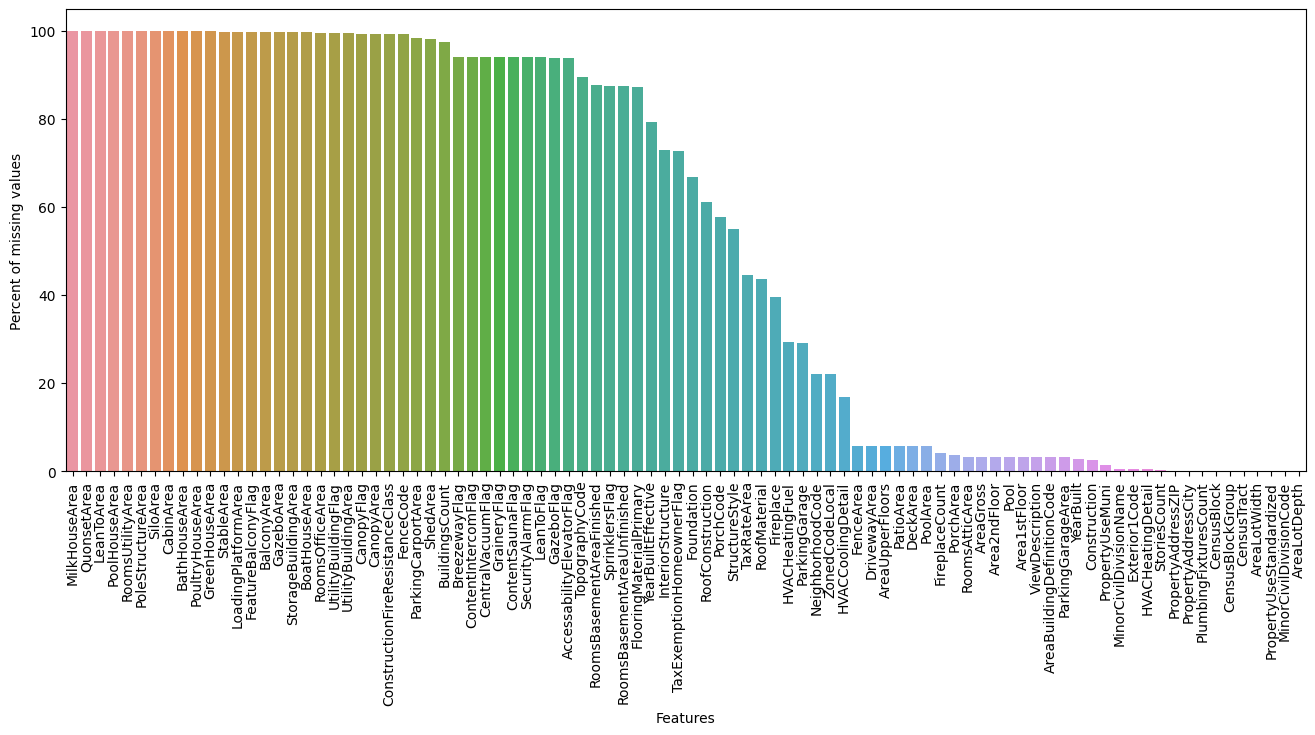

In [10]:
plt.figure(figsize=(16,6))
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Percent of missing values")

A lot of variables are suffereing from tons of missing values. However, imputation of missing values will be time-consuing, so models that can handle missing values will be preferred!


# Feature engineering

Let's look at the distribution of sale price. This is a weird right-skewed distribution. Thus, three ways have been tried to make it more 'normal'.

- Truncate sale price (95% quantile asa threshold)
- log transformation -> **works the best**
- sqrt transformation

<ipython-input-11-ad7a0beefc80>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['SalePrice'], color='g', hist_kws={'alpha': 0.4}, ax=axs[0])
<ipython-input-11-ad7a0beefc80>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['logSalePrice'], color='g', hist_kws={'alpha': 0.4}, ax=axs[

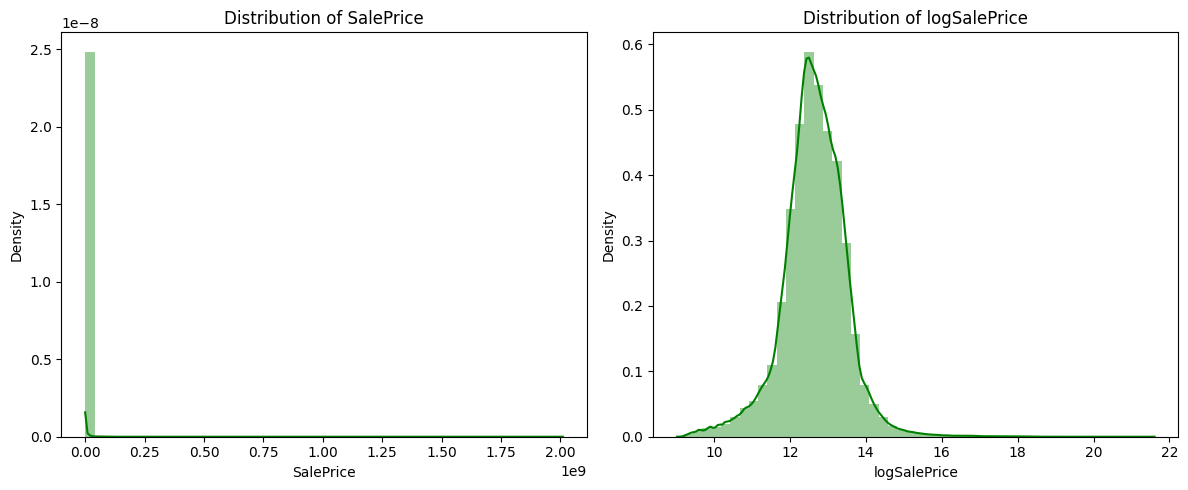

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.distplot(train['SalePrice'], color='g', hist_kws={'alpha': 0.4}, ax=axs[0])
axs[0].set_title('Distribution of SalePrice')

train['logSalePrice'] = train['SalePrice'].transform(lambda x:np.log(x))
sns.distplot(train['logSalePrice'], color='g', hist_kws={'alpha': 0.4}, ax=axs[1])
axs[1].set_title('Distribution of logSalePrice')

plt.tight_layout()
plt.show()


It's better after log tranformation.

Then I add record year and month as new variables.
From the heatmap, it's easy to see from top to botton and left to right, housing prices gradually increase.

In [12]:
train['RecordingDate'] = pd.to_datetime(train['RecordingDate'])
train['RecordMonth'] = train['RecordingDate'].map(lambda x: x.month).astype('float64')
train['RecordYear'] = train['RecordingDate'].map(lambda x: x.year).astype('float64')

<ipython-input-14-053344199793>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_table = grouped.pivot("RecordYear", "RecordMonth", "logSalePrice")


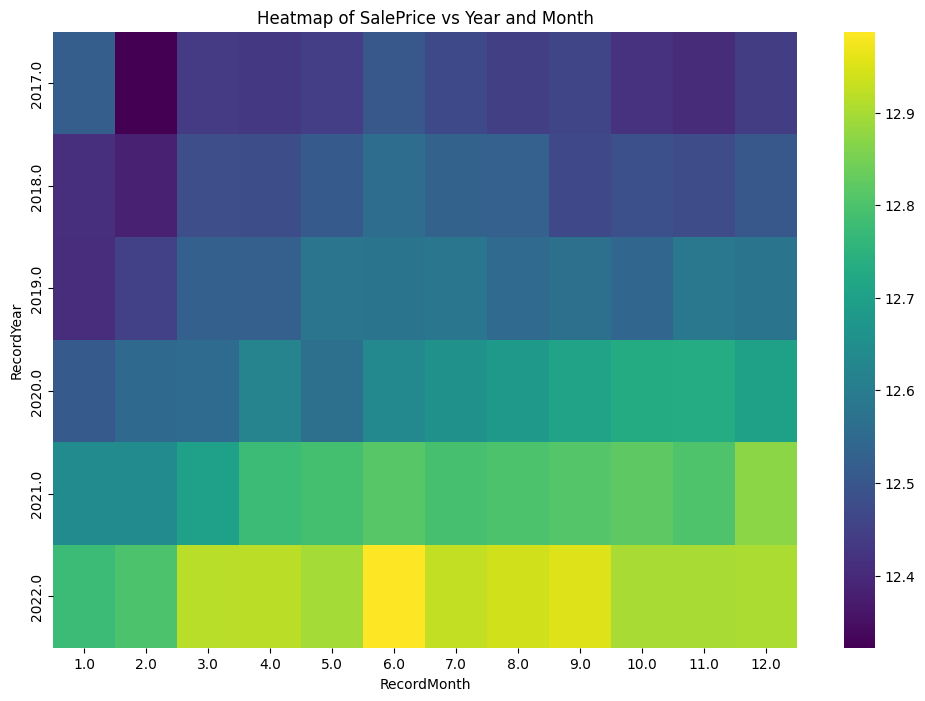

In [14]:
grouped = train.groupby(['RecordYear', 'RecordMonth'])['logSalePrice'].mean().reset_index()

pivot_table = grouped.pivot("RecordYear", "RecordMonth", "logSalePrice")

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, fmt=".0f", cmap='viridis')
plt.title('Heatmap of SalePrice vs Year and Month')
plt.show()

After all the preprocessing steps above, variables selected are saved in *variables.txt*

# Modelling

This dataset contains a mix of numeric, categorical and missing features. TF-DF supports all these feature types natively, and no preprocessing is required. This is one advantage of tree-based models, making them a great entry point to Tensorflow and ML.

## Select a Model

There are several tree-based models for you to choose from.

* RandomForestModel
* GradientBoostedTreesModel
* CartModel
* DistributedGradientBoostedTreesModel

To start, we'll work with a Random Forest. This is the most well-known of the Decision Forest training algorithms.

A Random Forest is a collection of decision trees, each trained independently on a random subset of the training dataset (sampled with replacement). The algorithm is unique in that it is robust to overfitting, and easy to use.



The following are pseducode, please check eda_v1.ipynb, gbm_tune.py and random_forest_tune.py for more information.

* First try: [GOOD]


    rf = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)

* Second try: [GOOD]


    gbt = tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.REGRESSION)

* Third try: Averaging their predictions. [SLIGHTLY IMPROVEMENT]

* Fourth try: Tuning parameters. [IMPROVED A LOT]

See tables below for more information

* Final try: Ensemble fine-tuned models. [DONE!]





## Model performance


**Hyperparameter selection**

| Models | Best Parameters | Search Space |  |
| --- | --- | --- | --- |
| Random Forests | num_trees = 1000 | Until OOB metric stops decreasing |
| | max_depth = 30 | [10, 20, 25, 30, 50] |
| | attributes_ratio = 0.1  | [0.1, 0.15, 0.2, 0.25, 0.3, 0.4] |
| Gradient Boosting Tree | num_trees = 300, min_examples = 6, | [200,300,400,500],[6,7,8,9]|
| |                        growing_strategy = "LOCAL",  |["LOCAL","BEST_FIRST_GLOBAL"]|
| |                        use_hessian_gain = False, | [T,F] |
| |                        um_candidate_attributes_ratio = 0.6,| [0.2, 0.4, 0.5, 0.6, 0.7, 0.9]) |
| |                        shrinkage = 0.15 |[0.02, 0.05, 0.10, 0.15, 0.2, 0.25]|
| | max_depth = 10| [3, 4, 5, 6,8, 10, 12, 15, 20] |


In [ ]:
gbt = pd.read_csv('gbt.csv', index_col=0)
gbt.sort_values('score', ascending=False).head(5)


,score,evaluation_time,best,num_trees,min_examples,growing_strategy,max_num_nodes,use_hessian_gain,shrinkage,num_candidate_attributes_ratio,max_depth
49,-0.326847,8818.052393,True,300,6,LOCAL,NaN,False,0.15,0.6,10.0
5,-0.330260,3028.845075,False,500,8,LOCAL,NaN,True,0.20,0.5,12.0
44,-0.330330,7787.425816,False,500,9,BEST_FIRST_GLOBAL,128.0,False,0.15,0.7,NaN
47,-0.331380,8085.883671,False,300,9,LOCAL,NaN,True,0.15,0.7,15.0
30,-0.331827,7058.045663,False,500,9,LOCAL,NaN,True,0.25,0.5,8.0


In [ ]:
rf = pd.read_csv('rf.csv', index_col=0)
rf.sort_values('score', ascending=False).head(5)

,score,evaluation_time,best,max_depth,num_trees,num_candidate_attributes_ratio
29,-0.283607,2346.248998,True,30,1000,0.1
72,-0.283671,8549.611858,False,30,600,0.1
56,-0.283672,7282.543192,False,30,800,0.1
31,-0.283836,2387.857367,False,30,500,0.1
14,-0.283884,1292.250705,False,20,1000,0.1


## Model training and Model composition

In [ ]:
from tqdm import tqdm
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import scipy

In [ ]:
# datasets after filling out missing values
train = pd.read_pickle('train_do.pkl')
test = pd.read_pickle('test_do.pkl')

In [ ]:
label = 'SalePrice'

train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train, label=label, task = tfdf.keras.Task.REGRESSION)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test, task = tfdf.keras.Task.REGRESSION)

GBT = tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.REGRESSION,
                                           num_trees = 300, min_examples = 6, growing_strategy = "LOCAL",
                                           use_hessian_gain = False, shrinkage = 0.15,
                                           num_candidate_attributes_ratio = 0.6,
                                           max_depth = 10, random_seed=1111)
GBT.fit(train_ds, verbose=2)

In [ ]:
GBT2 = tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.REGRESSION,
                                           num_trees = 500, min_examples = 8, growing_strategy = "LOCAL",
                                           use_hessian_gain = True, shrinkage = 0.2,
                                           num_candidate_attributes_ratio = 0.5,
                                           max_depth = 12, random_seed=2222)
GBT2.fit(train_ds)

In [ ]:
rf = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION, num_trees=1000,
                                  max_depth=30, num_candidate_attributes_ratio = 0.1, random_seed=0)



rf.fit(x=train_ds, verbose=2)

Prediction

In [ ]:
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    test,
    task = tfdf.keras.Task.REGRESSION)

test_data = pd.read_csv("test_data.csv")
ids = test_data.pop('RecordID')

In [ ]:
preds_gbt = GBT.predict(test_ds)
preds_gbt2 = GBT2.predict(test_ds)
preds_rf = rf.predict(test_ds)

final_solution = np.concatenate([preds_rf, preds_gbt,preds_gbt2],axis=1)
final_solution = np.mean(final_solution,axis=1)

output = pd.DataFrame({'RecordID': ids,
                       'SalePrice': np.exp(final_solution.squeeze())})

output.to_csv('submission_tfdf_comp.csv', index=False)

# Summary

This dataset contains a large number of samples and variables. After excluding variables with only one value or with a standard deviation of zero, approximately 100 variables remain.

Thoughts before modeling:

- Normalize the sale price to be closer to a normal distribution before modeling.
- I want to use a baseline model that can accept various types of variables as input (numerical, categorical). I have tried neural networks, which tend to overfit and underperform compared to the mean sale price.
- There are many variables with a large proportion of missing values. Fortunately, tree-based models can handle this.
- Manually performing variable selection would be time-consuming, so I plan to tune the proportion of variables used when splitting branches. This approach will decorrelate trees and facilitate variable selection.

Thoughs after several tries:
- Random Forest (RF) performs the best, but it is not meaningful to ensemble several RF models.
- Gradient Boosting Trees (GBT) work satisfactorily.
- Ensemble learning shows even better performance and should be more stable.
